# 네이버 영화 리뷰 감성 분석

    차이점 : 
        1. 기존의 레이블된 데이터 대신 새로 레이블된 데이터 사용(naver_movie_reviews_ver2.csv)
        2. CNN 모델의 경우 일시정지 시키지 않고 끝까지 학습시킴(overfitting 발생 -> 얼마나 차이가 나는지 확인)

## 1. 데이터 처리

In [1]:
import pandas as pd

df = pd.read_csv('naver_movie_reviews_ver2.csv')
df.head()
print("data size : ",len(df))

data size :  712404


In [2]:
# review 중복 제거, null 값 제거

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print("data size : ",len(df))

data size :  690440


In [3]:
# review 데이터 한글, 공백 제외 제거

df['review'] = df['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
df.head()

<ipython-input-3-ea4cbfc0358c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')


,review,label
0,종합 평점은 점 드립니다,0
1,원작이 칭송받는 이유는 웹툰 계 자체의 질적 저하가 심각하기 때문 원작이나 영화나...,0
2,나름의 감동도 있고 안타까운 마음에 가슴도 먹먹 배우들의 연기가 김수현 최고,2
3,이런걸 돈주고 본 내자신이 후회스럽다 최악의 쓰레기 영화 김수현 밖에없는 저질 삼류영화,0
4,초반엔 코미디 후반엔 액션 결론은 코미디,1


In [4]:
# 영어 review 있었는 지 확인
df.isnull().sum()

review    0
label     0
dtype: int64

2    363426
1    208595
0    118419
Name: label, dtype: int64


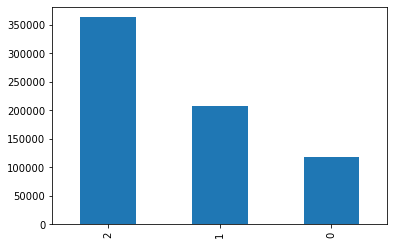

In [5]:
df['label'].value_counts().plot(kind='bar')
print(df['label'].value_counts())

max length :  140
mean length :  33.37488992526505


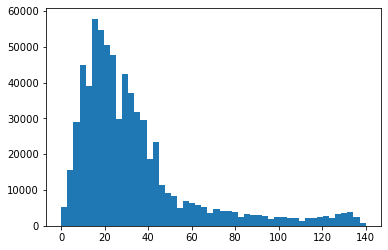

In [6]:
import numpy as np
import matplotlib.pyplot as plt

print("max length : ",max(len(review) for review in df['review']))
print("mean length : ",np.mean([len(review) for review in df['review']]))
plt.hist([len(review) for review in df['review']],bins=50);

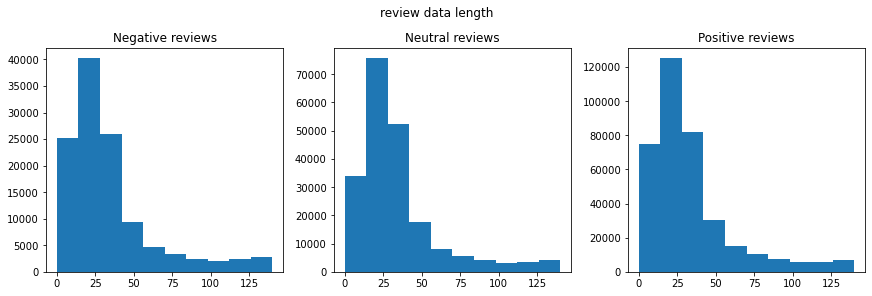

In [7]:
fig, axes = plt.subplots(1,3,figsize=(12,4),constrained_layout=True)
fig.suptitle("review data length")

axes[0].hist([len(review) for review,label in zip(df['review'],df['label']) if label == 0])
axes[0].set_title("Negative reviews")
axes[1].hist([len(review) for review,label in zip(df['review'],df['label']) if label == 1])
axes[1].set_title("Neutral reviews")
axes[2].hist([len(review) for review,label in zip(df['review'],df['label']) if label == 2])
axes[2].set_title("Positive reviews");

0    100000
1    100000
2    100000
Name: label, dtype: int64


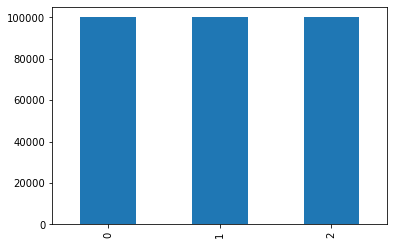

In [8]:
# 데이터가 긍정 레이블에 치중되어 있다. -> 100,000개로 맞춰준다. 
# 리뷰 길이의 분포는 각 레이블 별 유사하다.


df = df.sample(frac=1).groupby('label').head(100000)
df['label'].value_counts().plot(kind='bar')
print(df['label'].value_counts())

In [9]:
# train / test 데이터 나눠준다.

from sklearn.model_selection import train_test_split

X = df['review']
y = df['label']

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print("train size : ",len(X_train_data))
print("test size : ",len(X_test_data))

train size :  240000
test size :  60000


## 텍스트 처리
    한글 자연어 처리 라이브러리인 Okt 사용.
    불용어는 https://bab2min.tistory.com/544 참고. 

In [11]:
f = open('stopwords.txt')
stopwords = []
for line in f :
    stopwords.append(line.split("\t")[0])

print(len(stopwords))

100


In [12]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()

X_train_token = []
for sent in tqdm(X_train_data) :
    tmp = [] 
    tmp = okt.morphs(sent,stem=True)
    tmp = [word for word in tmp if word not in stopwords]
    X_train_token.append(tmp)

X_train_token[:3]

100%|██████████| 240000/240000 [04:24<00:00, 907.06it/s] 


[['보다', '별로'],
 ['본',
  '좌',
  '는',
  '공각기동대',
  '늘다',
  '별로',
  '다',
  '앞머리',
  '길다',
  '쿠',
  '사',
  '나기',
  '모도',
  '코',
  '가다',
  '그리다'],
 ['사다', '진미', '를', '망치다', '버리다', '각본']]

In [13]:
X_test_token = []
for sent in tqdm(X_test_data) :
    tmp = [] 
    tmp = okt.morphs(sent,stem=True)
    tmp = [word for word in tmp if word not in stopwords]
    X_test_token.append(tmp)
    
X_test_token[:3]

100%|██████████| 60000/60000 [01:16<00:00, 784.27it/s]


[['유덕화', '짱'],
 ['일본', '역사', '에', '관심', '이다', '볼', '만'],
 ['안보',
  '다',
  '오랜',
  '만',
  '에',
  '본방',
  '보다',
  '재미',
  '너무',
  '없다',
  '진짜',
  '전면',
  '개편',
  '필요하다',
  '듯']]

In [14]:
# threshold 확인

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_token)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0   # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 53445
등장 빈도가 2번 이하인 희귀 단어의 수: 29091
단어 집합에서 희귀 단어의 비율: 54.431658714566375
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2946640941766827


In [15]:
# 0번 패딩 토큰 , 1번 OOV 토큰 고려 +2
vocab_size = total_cnt - rare_cnt + 2 
print(vocab_size)

24356


In [16]:
# 정수 인코딩
tokenizer = Tokenizer(num_words=vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(X_train_token)
X_train = tokenizer.texts_to_sequences(X_train_token)
X_test = tokenizer.texts_to_sequences(X_test_token)

In [17]:
import numpy as np

y_train = np.array(y_train_data)
y_test = np.array(y_test_data)

In [18]:
# 빈도수 낮은 단어 삭제 -> 빈 샘플 존재

drop_idx = [idx for idx, sent in enumerate(X_train) if len(sent) < 1]

X_train = np.delete(X_train,drop_idx,axis=0)
y_train = np.delete(y_train,drop_idx,axis=0)

print("X_train size : ",len(X_train))
print("y_train size : ",len(y_train))

X_train size :  238786
y_train size :  238786


## 패딩

max length of reivews :  68
mean length of reivews :  11.523619475178611


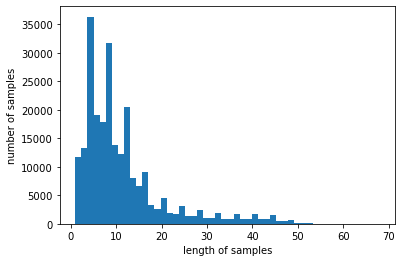

In [19]:
import matplotlib.pyplot as plt

print("max length of reivews : ",max(len(word) for word in X_train))
print("mean length of reivews : ",np.mean([len(word) for word in X_train]))
plt.hist([len(word) for word in X_train],bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [20]:
def belowThreshold(thre, words) :
    cnt = 0
    for word in words:
        if(len(word) <= thre) :
            cnt += 1
    print(f"percentage of sample that shorter threshold {thre} : {round((cnt / len(words)) * 100,3)}")
    
print("threshold : 30")
belowThreshold(30,X_train)
print("threshold : 40")
belowThreshold(40,X_train)

threshold : 30
percentage of sample that shorter threshold 30 : 93.629
threshold : 40
percentage of sample that shorter threshold 40 : 97.36


In [21]:
# 최대 길이 40으로 맞춤
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 40
X_train = pad_sequences(X_train,maxlen = max_len)
X_test = pad_sequences(X_test,maxlen = max_len)

In [22]:
# 원-핫 인코딩.
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

## 모델 구축

### 문장 예측 함수

In [23]:
def sent_predict(sent,model) :
    sent = okt.morphs(sent,stem=True)
    sent = [word for word in sent if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([sent])
    padded = pad_sequences(encoded,maxlen=max_len)
    score = model.predict(padded)
    idx = np.argmax(score[0])
    if idx == 0 :
        print("{} % Negative review".format(round(score[0][idx]*100,2)))
    elif idx == 1:
        print("{} % Neutral review".format(round(score[0][idx]*100,2)))
    else :
        print("{} % Positive review".format(round(score[0][idx]*100,2)))

### GRU

In [24]:
# 조기 종료 요건과 베스트 모델 저장
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)
mc = ModelCheckpoint('NAVER_GRU.h5',monitor='val_acc',mode='max',verbose=1,
                    save_best_only=True)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Embedding,Dense

model = Sequential()
model.add(Embedding(vocab_size,100))
model.add(GRU(128))
model.add(Dense(3,activation='softmax'))

In [26]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(X_train,y_train,epochs=15,callbacks=[es,mc],
          batch_size=60,validation_split=0.2)

Epoch 1/15
3184/3184 [==============================] - 214s 67ms/step - loss: 0.8438 - acc: 0.5997 - val_loss: 0.7613 - val_acc: 0.6544

Epoch 00001: val_acc improved from -inf to 0.65445, saving model to NAVER_GRU.h5
Epoch 2/15
3184/3184 [==============================] - 212s 67ms/step - loss: 0.6883 - acc: 0.6964 - val_loss: 0.7636 - val_acc: 0.6553

Epoch 00002: val_acc improved from 0.65445 to 0.65526, saving model to NAVER_GRU.h5
Epoch 3/15
3184/3184 [==============================] - 214s 67ms/step - loss: 0.6157 - acc: 0.7337 - val_loss: 0.7851 - val_acc: 0.6508

Epoch 00003: val_acc did not improve from 0.65526
Epoch 4/15
3184/3184 [==============================] - 213s 67ms/step - loss: 0.5441 - acc: 0.7696 - val_loss: 0.8619 - val_acc: 0.6409

Epoch 00004: val_acc did not improve from 0.65526
Epoch 5/15
3184/3184 [==============================] - 215s 67ms/step - loss: 0.4657 - acc: 0.8034 - val_loss: 0.9636 - val_acc: 0.6296

Epoch 00005: val_acc did not improve from 0.6

In [27]:
print("model accuracy : ",model.evaluate(X_test,y_test)[1])

1875/1875 [==============================] - 34s 18ms/step - loss: 0.9492 - acc: 0.6268
model accuracy :  0.6268333196640015


In [28]:
sent_predict("하이틴 로맨스로 시작해서 퀴어로 끝난다. 연출은 부족하지만, 시도는 놀랍다.",model) 

75.41 % Neutral review


In [29]:
sent_predict('내용 부터가 좀 지금 시대로써는 공감ㄴㄴ 피노키오 재미있던데 왜이런 드라마가 수목 시청률위인지 모르겠어',model)

95.72 % Negative review


In [30]:
sent_predict('역시 뽀통령은 최고다',model)

56.95 % Neutral review


## Conv

In [31]:
# 조기 종료 요건과 베스트 모델 저장
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

mc = ModelCheckpoint('NAVER_CONV.h5',monitor='val_acc',mode='max',verbose=1,
                    save_best_only=True)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding

CNN = Sequential()
CNN.add(Embedding(vocab_size,256))
CNN.add(Dropout(0.3))
CNN.add(Conv1D(256,3,padding='valid',activation='relu'))
CNN.add(GlobalMaxPooling1D())
CNN.add(Dense(128,activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(3,activation='softmax'))

In [33]:
CNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

CNN.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),callbacks=[mc])

Epoch 1/15
7463/7463 [==============================] - 129s 17ms/step - loss: 0.8734 - acc: 0.5882 - val_loss: 0.7747 - val_acc: 0.6455

Epoch 00001: val_acc improved from -inf to 0.64552, saving model to NAVER_CONV.h5
Epoch 2/15
7463/7463 [==============================] - 128s 17ms/step - loss: 0.7428 - acc: 0.6740 - val_loss: 0.7822 - val_acc: 0.6529

Epoch 00002: val_acc improved from 0.64552 to 0.65287, saving model to NAVER_CONV.h5
Epoch 3/15
7463/7463 [==============================] - 130s 17ms/step - loss: 0.6813 - acc: 0.7082 - val_loss: 0.7924 - val_acc: 0.6524

Epoch 00003: val_acc did not improve from 0.65287
Epoch 4/15
7463/7463 [==============================] - 130s 17ms/step - loss: 0.6128 - acc: 0.7454 - val_loss: 0.8178 - val_acc: 0.6471

Epoch 00004: val_acc did not improve from 0.65287
Epoch 5/15
7463/7463 [==============================] - 135s 18ms/step - loss: 0.5476 - acc: 0.7769 - val_loss: 0.8799 - val_acc: 0.6392

Epoch 00005: val_acc did not improve from 0

In [34]:
print("model accuracy : ",CNN.evaluate(X_test,y_test)[1])

1875/1875 [==============================] - 3s 2ms/step - loss: 1.9591 - acc: 0.6198
model accuracy :  0.6198166608810425


In [35]:
from tensorflow.keras.models import load_model

loaded_model = load_model('NAVER_CONV.h5')

In [36]:
print("model accuracy : ",loaded_model.evaluate(X_test,y_test)[1])

1875/1875 [==============================] - 3s 2ms/step - loss: 0.9100 - acc: 0.6326
model accuracy :  0.6325666904449463


과적합된 모델과 중간에 정지시킨 모델과의 정확도 차이점이 대략 2%

과적합되긴 했으나 큰 차이를 보이진 않는다.

In [46]:
sent_predict("하이틴 로맨스로 시작해서 퀴어로 끝난다. 연출은 부족하지만, 시도는 놀랍다.",loaded_model) 

63.23 % Negative review


In [42]:
sent_predict('내용 부터가 좀 지금 시대로써는 공감ㄴㄴ 피노키오 재미있던데 왜이런 드라마가 수목 시청률위인지 모르겠어',loaded_model)

97.15 % Negative review


In [43]:
sent_predict('역시 뽀통령은 최고다',loaded_model)

98.19 % Positive review


중립에 대한 감성 분석을 하는게 어렵다. 

단순히 평점만으로 이걸 구분짓는게 쉽지 않다.

평점을 (1-4) / (5-7) / (8-10) 으로 나누지 말고 

중립 데이터는 확실하게 해야 되는 거 같다. -> 평점은 7점이지만 리뷰가 긍정적으로 써있는 경우 , 그 반대의 경우도 그렇듯